In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Dense, Concatenate, LSTM, Lambda

In [3]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model

**Model to predict the type of songs - tap dance, ballet etc**

Input - audio and poses of a song
Output - type of song (ballet, tap etc) in the form of one hot encoding.

One hot encoding - Assume there are 4 types of dances- tap, ballet, hip hop and break. Heres how the outputs would look

0001 - tap

0010 - ballet

0100 - hip hop

1000 - break

In [4]:
import numpy as np
import librosa
import json

In [5]:
#labelling the data1

import os

folder_path = "/content/drive/MyDrive/Summer_Internship_Data/Datasets"  # Replace with the actual path to your "Datasets" folder
output_array = []

# Iterate over the files in the folder
for filename in sorted(os.listdir(folder_path)):
    if filename.endswith("_data.json"):  # Consider only files ending with "_data.json"
        name = filename.split("_data")[0]  # Extract the name by removing "_data" suffix
        dance_form = ''.join([i for i in name if not i.isdigit()])  # Remove numeric part from the name
        output_array.append(dance_form)

In [6]:
import os

filenames = sorted(os.listdir('/content/drive/MyDrive/Summer_Internship_Data/Datasets'))

In [7]:
len(filenames)

25

In [8]:
filenames = sorted(os.listdir('/content/drive/MyDrive/Summer_Internship_Data/Processed_audios'))
len(filenames)

25

In [9]:
import json
import os
import librosa

pose_path = '/content/drive/MyDrive/Summer_Internship_Data/Datasets'
pose_files = [f for f in os.listdir(pose_path) if f.endswith('.json')]

pose_data = []
for pose_data_file in pose_files:
  try:
    with open(os.path.join(pose_path, pose_data_file), "r") as f:
        pose_data.append(json.load(f))
  except Exception as e:
    print(f"Error loading file {pose_data_file}: {e}")

audio_path = '/content/drive/MyDrive/Summer_Internship_Data/Processed_audios'
audio_files = sorted(f for f in os.listdir(audio_path) if f.endswith('.wav'))
preprocessed_audio = []
for audio_file in audio_files:
  try:
    audio, sr = librosa.load(os.path.join(audio_path, audio_file), sr=None)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)  # Convert to dB scale
    preprocessed_audio.append(spectrogram)
  except Exception as e:
    print(f"Error loading file {audio_file}: {e}")


In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np

# Initialize the one-hot encoder
onehot_encoder = OneHotEncoder(sparse=False)

# Fit and transform the output array with one-hot encoder
onehot_encoded = onehot_encoder.fit_transform(np.array(output_array).reshape(-1, 1))

# Print the one-hot encoded array
print(onehot_encoded)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
if len(preprocessed_audio) > 0:
    audio_shape = np.array(preprocessed_audio[0]).shape
    print(audio_shape)
else:
    print("The preprocessed_audio list is empty.")


(128, 2617)


In [12]:
np.array(preprocessed_audio[1]).shape

(128, 13205)

In [13]:
import numpy as np

# Dataset of shape (26, 128, n)
dataset = preprocessed_audio  # Replace ... with the actual variable containing the mel spectrogram data

# Step 1: Find the longest length
max_length = max([audio_clip.shape[1] for audio_clip in dataset])

# Step 2: Insert End of Song token
eos_token = np.zeros((128, 1))  # Assuming 128 is the height of the mel spectrogram
dataset_with_eos = [np.concatenate((audio_clip, eos_token), axis=1) for audio_clip in dataset]

# Step 3: Pad audio clips with 0's
padded_dataset = [np.pad(audio_clip, ((0, 0), (0, max_length - audio_clip.shape[1] + 1)), mode='constant', constant_values=0) for audio_clip in dataset_with_eos]

# Step 4: Convert the list to a numpy array
padded_array = np.array(padded_dataset)

print(padded_array.shape)


(25, 128, 17184)


In [14]:
min_length = float('inf')  # Initialize with a large value

for pose_data_file in pose_data:
    length = len(pose_data_file)
    if length < min_length:
        min_length = length

print('Minimum length:', min_length)

Minimum length: 911


In [15]:
pose_data = [np.array(x)[:min_length, :, :] for x in pose_data]

In [16]:
import numpy as np

# Assuming preprocessed_audio is a list of arrays with varying shapes

# Step 1: Find the maximum shape
max_shape = max([audio.shape for audio in preprocessed_audio])

# Step 2: Truncate or pad the arrays to have the same shape
padded_audio = []
for audio in preprocessed_audio:
    # Pad or truncate the array to the maximum shape
    padded_audio.append(np.pad(audio, [(0, max_shape[0] - audio.shape[0]), (0, max_shape[1] - audio.shape[1])], mode='constant'))

# Step 3: Create the NumPy array with dtype=object
preprocessed_audio = np.array(padded_audio)

**Your audio files are of different lengths and so are your video files. FIX THIS BEFORE GOING AHEAD**

In [17]:
pose_data = np.array(pose_data, dtype=np.float)
preprocessed_audio = np.array(preprocessed_audio, dtype=np.float)
onehot_encoded = np.array(onehot_encoded, dtype=np.float)

<ipython-input-17-2c6389482fc7>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pose_data = np.array(pose_data, dtype=np.float)
<ipython-input-17-2c6389482fc7>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preprocessed_audio = np.array(preprocessed_audio, dtype=np.float)
<ipython-input-17-2c6389482fc7>:3: DeprecationWarning: `np.float

In [18]:
pose_data.shape

(25, 911, 33, 3)

In [19]:
preprocessed_audio.shape

(25, 128, 17183)

In [20]:
onehot_encoded.shape

(25, 6)

In [21]:
from tensorflow.keras.layers import Input, Dropout, Conv2D, MaxPooling2D, GRU, Dense, Flatten, Concatenate, LeakyReLU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

video_input = Input(shape=(911, 33, 3))
audio_input = Input(shape=(128, 17183))

# Modify the number of classes according to your one-hot encoded labels
num_classes = onehot_encoded.shape[1]

x1 = Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.0001))(video_input)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Conv2D(64, kernel_size=(3, 3), activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.0001))(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Flatten()(x1)

x2 = Bidirectional(GRU(64, kernel_regularizer=regularizers.l2(0.0001), return_sequences=True))(audio_input)
x2 = Bidirectional(GRU(64, kernel_regularizer=regularizers.l2(0.0001)))(x2)

x = Concatenate()([x1, x2])
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[video_input, audio_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit([pose_data, preprocessed_audio], onehot_encoded, batch_size=8, epochs=100, validation_split=0.2)

print(model.evaluate(x=[pose_data, preprocessed_audio], y=onehot_encoded, batch_size=8))


Epoch 1/100
3/3 [==============================] - 21s 989ms/step - loss: 4.0310 - accuracy: 0.1500 - val_loss: 3.3407 - val_accuracy: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 102ms/step - loss: 4.2511 - accuracy: 0.2000 - val_loss: 4.8355 - val_accuracy: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 106ms/step - loss: 3.6607 - accuracy: 0.2000 - val_loss: 7.0148 - val_accuracy: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 104ms/step - loss: 3.3766 - accuracy: 0.2500 - val_loss: 5.3698 - val_accuracy: 0.2000
Epoch 5/100
3/3 [==============================] - 0s 114ms/step - loss: 4.4372 - accuracy: 0.2000 - val_loss: 3.9463 - val_accuracy: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 103ms/step - loss: 5.5409 - accuracy: 0.2500 - val_loss: 3.7050 - val_accuracy: 0.0000e+00
Epoch 7/100
3/3 [==============================] - 0s 109ms/step - loss: 3.6219 - accuracy: 0.3500 - val_loss: 3.2505 - val_accuracy:

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 911, 33, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 909, 31, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 454, 15, 64)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 452, 13, 64)  36928       ['max_pooling2d[0][0]']      

In [23]:
import tensorflow as tf
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  # Train the model with your data
  model.fit([pose_data, preprocessed_audio], onehot_encoded, batch_size=16, epochs=100, callbacks=[callback], validation_split=0.2)


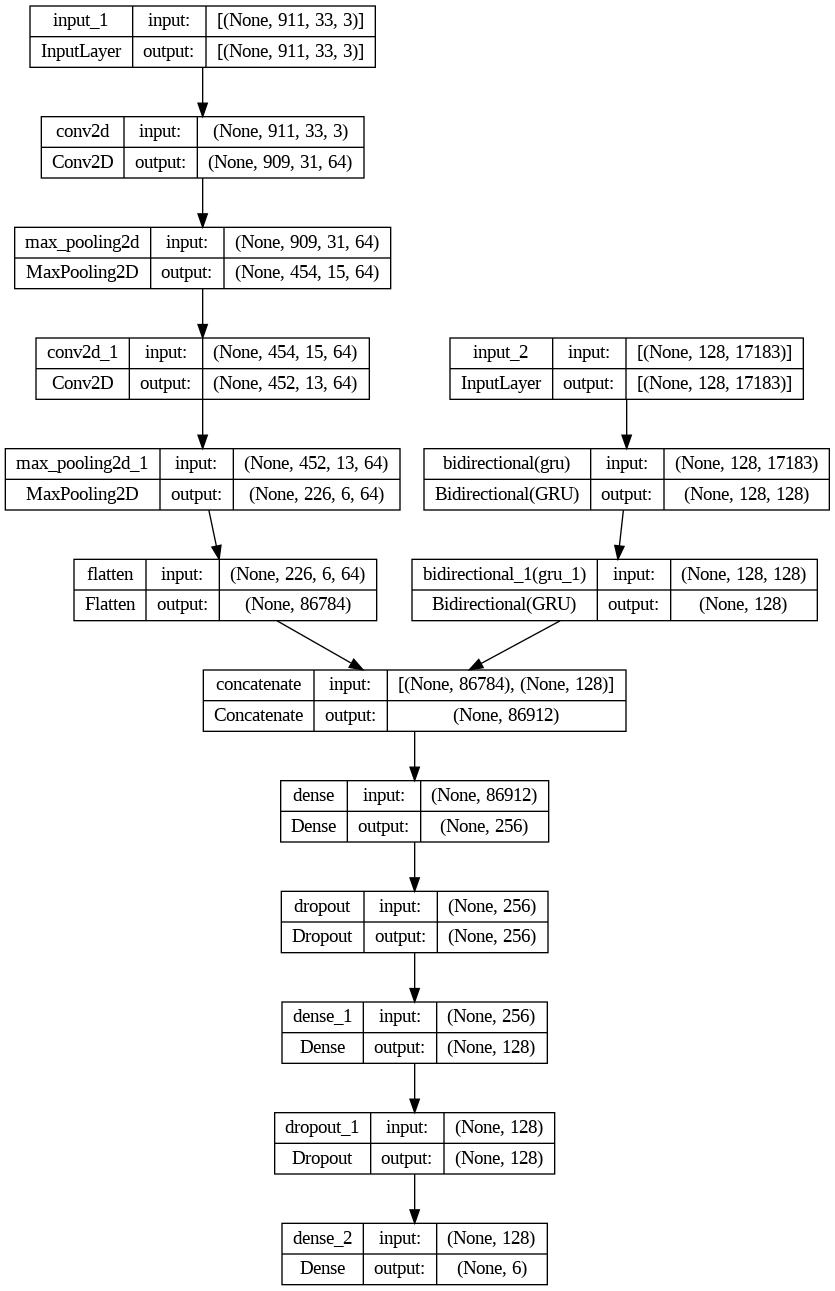

In [24]:
plot_model(model, show_shapes = True)

In [25]:
model.save('dance_classifierv3.hdf5')

**Model to predict similarity between 2 songs using Siamese Network**<br/>
Input - there are 4 inputs: audio of song 1, poses of song 1, audio of song 2 and video of song 2. <br/>
Output - A score between 0 & 1 of how similar 2 songs are. <br/>

How to use:
Predict the score for ever pair of songs. If given a song (audio and video) you are asked to recommend another song, just return the song that has the highest similarity score with your given song.

How to train: Watch this youtube video https://www.youtube.com/watch?v=6jfw8MuKwpI&pp=ygUZYW5kcmV3IG5nIHNpYW1lc2UgbmV0d29yaw%3D%3D


In [26]:
# # Assuming you have loaded the model and prepared the input data as described in the previous steps

# # Make predictions
# predictions = model.predict(inputs)

# # Interpret predictions
# predicted_classes = np.argmax(predictions, axis=1)

# # Get the ground truth labels
# ground_truth = np.argmax(onehot_encoded, axis=1)

# # Calculate accuracy
# accuracy = np.sum(predicted_classes == ground_truth) / len(ground_truth)

# print("Accuracy:", accuracy)


In [27]:
# import tensorflow as tf

# model = tf.keras.models.load_model('/content/dance_classifierv3.hdf5')


In [28]:
# from tensorflow.keras.models import Model

# # Define the input layers
# video_input = model.input[0]
# audio_input = model.input[1]

# # Get the desired layer for feature extraction
# desired_layer = model.layers[-4]  # Replace with the appropriate layer index

# # Create the feature extraction model
# extract_features = Model(inputs=[video_input, audio_input], outputs=desired_layer.output)
# #

In [29]:
# from tensorflow.keras import backend as K

# pose_input_0 = Input(shape=(5384, 33, 3))
# audio_input_0 = Input(shape=(128, 17183))
# pose_input_1 = Input(shape=(5384, 33, 3))
# audio_input_1 = Input(shape=(128, 17183))

# features_1 = extract_features([pose_input_0[:, :911], audio_input_0[:, :128]])
# features_2 = extract_features([pose_input_1[:, :911], audio_input_1[:, :128]])


# def cosine_similarity(vectors):
#     x, y = vectors
#     x = K.l2_normalize(x, axis=-1)
#     y = K.l2_normalize(y, axis=-1)
#     return K.sum(x * y, axis=-1, keepdims=True)

# similarity = Lambda(cosine_similarity)([features_1, features_2])

# # Create the Siamese network
# siamese_model = Model(inputs=[pose_input_0, audio_input_0, pose_input_1, audio_input_1], outputs=similarity)

In [30]:
# plot_model(siamese_model, show_shapes=True)

In [31]:
# siamese_model.summary()